In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt
try:
    import intel_extension_for_pytorch as ipex
except:
    pass
from mnist import MNIST
# import intel_extension_for_pytorch as ipex
import time
import tqdm

# Dataset
from data import DeviceDataset
from networks import *

# Torch
from torch.utils.data import DataLoader
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn

# Sci-kit Data Split
from sklearn.model_selection import train_test_split

In [2]:
device = "xpu:0" if torch.xpu.is_available() else "cpu"
device

'cpu'

In [3]:
data = MNIST('data')

images, labels = data.load_testing()

In [4]:
def image_prep(images):
    images = np.array(images)
    images = images.reshape(-1, 28, 28).astype(np.float32)
    images = images / 255.0
    images[images > 0] = 1
    images = np.expand_dims(images, axis=1)
    return images

In [5]:
# Send images to image_prep function
images = image_prep(images)

# Plot Image 1
print(images[0].shape)
print(labels[0])
# plt.imshow(images[0], cmap='gray')

(1, 28, 28)
7


In [6]:
# Split the Data into training and temporary sets
random_val = 10
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=random_val)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_val)

# Load Data into Train, Validation, and Test Datasets
train_dataset = DeviceDataset(X_train, y_train, device)
val_dataset = DeviceDataset(X_val, y_val, device)
test_dataset = DeviceDataset(X_test, y_test, device)

In [7]:
# Send to DataLoader
batch = 512
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=True)

Text(0.5, 1.0, '6')

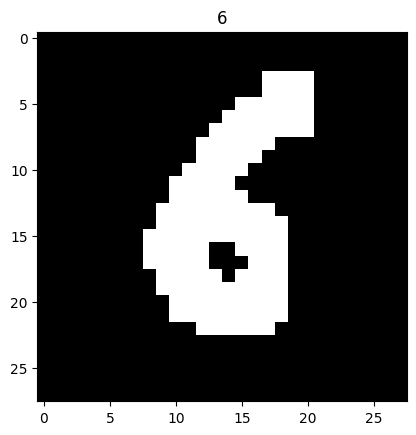

In [8]:
import random
ran_num = random.randint(0, len(train_loader))

# Show a Random Image from the Training Set with its label
plt.imshow(X_train[ran_num][0], cmap='gray')
plt.title(y_train[ran_num])

In [9]:
#######################################################
# VARIABLES
epochs = 50
learn = 0.01

dropoff_1 = 0.7
dropoff_2 = 0.5
dropoff_3 = 0.1
dropoff_4 = 0.1

debug=False
#######################################################

In [10]:
# Model, ResNet50
model = SimpleModel().to(device)

# Criterion, CrossEntropyLoss
criterion = nn.CrossEntropyLoss().to(device)

# Optimizer, SGDSGD...
optimizer = optim.SGD(model.parameters(), lr=learn)

In [11]:
# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 7008


In [12]:
highest_acc = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch+1) % 1 == 0:
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    if (epoch+1) % 1 == 0:
        print(f"Epoch: {epoch+1}, Loss: {(running_loss/len(train_loader)):.3f}, Accuracy: {(100 * correct / total):.3f} [{correct}/{total}]")
        if (100 * correct / total) > highest_acc:
            highest_acc = (100 * correct / total)
            # torch.save(model.state_dict(), "best_model.pth")

Input: torch.Size([512, 1, 28, 28])
Conv1: torch.Size([512, 25, 30, 30])
Pool1: torch.Size([512, 25, 15, 15])
Conv2: torch.Size([512, 3, 13, 13])
View: torch.Size([512, 507])
Linear: torch.Size([512, 10])
Epoch: 1, Loss: 2.306, Accuracy: 9.133 [137/1500]
Epoch: 2, Loss: 2.299, Accuracy: 12.200 [183/1500]
Epoch: 3, Loss: 2.289, Accuracy: 17.200 [258/1500]
Epoch: 4, Loss: 2.271, Accuracy: 22.800 [342/1500]
Epoch: 5, Loss: 2.237, Accuracy: 28.733 [431/1500]
Epoch: 6, Loss: 2.165, Accuracy: 34.133 [512/1500]
Epoch: 7, Loss: 2.029, Accuracy: 51.467 [772/1500]
Epoch: 8, Loss: 1.809, Accuracy: 61.000 [915/1500]
Epoch: 9, Loss: 1.533, Accuracy: 66.667 [1000/1500]
Epoch: 10, Loss: 1.270, Accuracy: 71.067 [1066/1500]
Epoch: 11, Loss: 1.068, Accuracy: 70.200 [1053/1500]
Epoch: 12, Loss: 0.930, Accuracy: 74.267 [1114/1500]
Epoch: 13, Loss: 0.831, Accuracy: 74.933 [1124/1500]
Epoch: 14, Loss: 0.779, Accuracy: 75.333 [1130/1500]
Epoch: 15, Loss: 0.720, Accuracy: 77.800 [1167/1500]
Epoch: 16, Loss: 0

In [13]:
# Save the Model to model/ folder, with name based on parameters used
model_name = f"SimpleCNN_{float(highest_acc):.3f}_{total_params}.pth"

# Check to see if models/ folder exists
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model
model.cpu()
torch.save(model.state_dict(), f'models/{model_name}')

Matrix Test

In [14]:
# 2 numpy arrays with zeros. custom dimensions
x = np.zeros((10, 15, 20))
print(x.shape)

y = np.zeros((10, 20, 30))
print(y.shape)

# Matrix Multiply
z = np.matmul(x, y)
print(f'\n{z.shape}')

(10, 15, 20)
(10, 20, 30)

(10, 15, 30)


In [15]:
# 2 Numpy 4D Arrays
x = np.zeros((10, 3, 15, 20))
print(x.shape)

y = np.zeros((10, 3, 20, 30))
print(y.shape)

# Matrix Multiply
z = np.matmul(x, y)
print(f'\n{z.shape}')

(10, 3, 15, 20)
(10, 3, 20, 30)

(10, 3, 15, 30)
